In [ ]:
pip install tensorflow-quantum

In [2]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
import random
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def make_data(n1, n2):
    qubit = cirq.GridQubit(0,0)
    train, test = [], []
    train_label, test_label = [], []
    for _ in range(n1):
        cir = cirq.Circuit()
        rot = random.uniform(0,0.1) if random.random() < 0.5 else random.uniform(0.9,1)
        cir.append([cirq.X(qubit)**rot])
        train.append(cir)
        if rot < 0.5:
            train_label.append(1)
        else:
            train_label.append(-1)
    for _ in range(n2):
        cir = cirq.Circuit()
        rot = random.uniform(0,0.1) if random.random() < 0.5 else random.uniform(0.9,1)
        cir.append([cirq.X(qubit)**rot])
        test.append(cir)
        if rot < 0.5:
            test_label.append(1)
        else:
            test_label.append(-1)
    return tfq.convert_to_tensor(train), np.array(train_label), tfq.convert_to_tensor(test), np.array(test_label)

In [4]:
def make_circuit(qubit):
    x = sympy.symbols('X_rot')
    y = sympy.symbols('Y_rot')
    z = sympy.symbols('Z_rot')
    c = cirq.Circuit()
    c.append(cirq.rx(x).on(qubit))
    c.append(cirq.ry(y).on(qubit))
    c.append(cirq.rz(z).on(qubit))
    return c

In [5]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [6]:
train, train_label, test, test_label = make_data(1000, 100)
qubit = cirq.GridQubit(0,0)
readout_operators = [cirq.X(qubit)]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
trial_circuit = make_circuit(qubit)
print(trial_circuit)
layer1 = tfq.layers.PQC(make_circuit(qubit), readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=layer1)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.hinge, metrics=[hinge_accuracy])
history = model.fit(train, train_label, epochs=64, batch_size=32, validation_data=(test, test_label))
print(model.trainable_weights)

(0, 0): ───Rx(X_rot)───Ry(Y_rot)───Rz(Z_rot)───
Epoch 1/64
Instructions for updating:
Use fn_output_signature instead
32/32 [==============================] - 1s 20ms/step - loss: 0.9696 - hinge_accuracy: 0.4990 - val_loss: 0.9400 - val_hinge_accuracy: 0.4922
Epoch 2/64
32/32 [==============================] - 0s 15ms/step - loss: 0.9377 - hinge_accuracy: 0.4990 - val_loss: 0.9231 - val_hinge_accuracy: 0.7578
Epoch 3/64
32/32 [==============================] - 0s 12ms/step - loss: 0.8846 - hinge_accuracy: 0.9775 - val_loss: 0.8456 - val_hinge_accuracy: 1.0000
Epoch 4/64
32/32 [==============================] - 0s 16ms/step - loss: 0.8012 - hinge_accuracy: 1.0000 - val_loss: 0.7763 - val_hinge_accuracy: 1.0000
Epoch 5/64
32/32 [==============================] - 0s 15ms/step - loss: 0.7621 - hinge_accuracy: 1.0000 - val_loss: 0.7475 - val_hinge_accuracy: 1.0000
Epoch 6/64
32/32 [==============================] - 1s 16ms/step - loss: 0.7248 - hinge_accuracy: 1.0000 - val_loss: 0.7125 - va

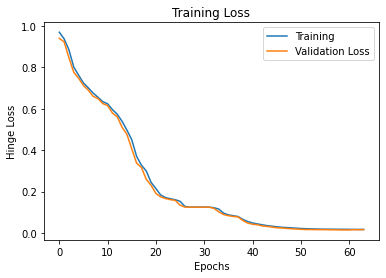

In [7]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Hinge Loss")
plt.show()

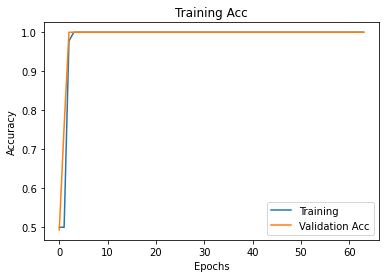

In [8]:
plt.plot(history.history['hinge_accuracy'], label='Training')
plt.plot(history.history['val_hinge_accuracy'], label='Validation Acc')
plt.legend()
plt.title("Training Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()